In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import time
from functions import basic
from functions import interaction
from functions import evolution
import main
%matplotlib inline

In [2]:
%%javascript
require(["codemirror/keymap/sublime", "notebook/js/cell", "base/js/namespace"],
    function(sublime_keymap, cell, IPython){
        cell.Cell.options_default.cm_config.keyMap = 'sublime';
        var cells = IPython.notebook.get_cells();
        for(var cl=0; cl< cells.length ; cl++){
            cells[cl].code_mirror.setOption('keyMap', 'sublime');
        }
    }
);

<IPython.core.display.Javascript object>

In [3]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

### Step-by-step part

In [4]:
# reading input file
filename = "fcc100a256.txt"
lattice = basic.read_file(filename)

In [5]:
# computing ditances, finding neighbours

# no PBC test
start = time.process_time()
for i in range(100):
    mask,distances = basic.find_neighbours(*lattice)
print(f'no PBC - 100 iterations; computing time: {time.process_time() - start :.2f} seconds')

start = time.process_time()
for i in range(100):
    mask,distances = basic.find_neighbours(*lattice, PBC=True)
print(f'PBC - 100 iterations; computing time: {time.process_time() - start :.2f} seconds')

no PBC - 100 iterations; computing time: 0.56 seconds
PBC - 100 iterations; computing time: 0.58 seconds


In [6]:
# calculating potential energy
mask,distances = basic.find_neighbours(*lattice)

# approximate LJ
start = time.process_time()
for i in range(100):
    LJA = interaction.lennard_jones_approx(distances)
print(f'approximate LJ - 100 iterations; computing time: {time.process_time() - start :.2f} seconds')

# true LJ
start = time.process_time()
for i in range(100):
    LJ = interaction.lennard_jones(distances)
print(f'true LJ - 100 iterations; computing time: {time.process_time() - start :.2f} seconds')

print('')
print(f'approximate LJ: {LJA:.2f}')
print(f'true LJ: {LJ:.2f}')

approximate LJ - 100 iterations; computing time: 0.73 seconds
true LJ - 100 iterations; computing time: 0.81 seconds

approximate LJ: -453.45
true LJ: -532.48


In [7]:
# calculating forces

# approximate LJ
start = time.process_time()
for i in range(100):
    FxA,FyA,FzA = interaction.calc_force_approx(*lattice,distances,PBC=True)
print(f'approximate LJ - 100 iterations; computing time: {time.process_time() - start :.2f} seconds')

# approximate LJ
start = time.process_time()
for i in range(100):
    Fx,Fy,Fz = interaction.calc_force(*lattice,distances,PBC=True)
print(f'true LJ - 100 iterations; computing time: {time.process_time() - start :.2f} seconds')

print('')
print(f'approximate LJ, force on 0-th atom: {FxA[1]:.2f},{FyA[1]:.2f},{FzA[1]:.2f}')
print(f'true LJ, force on 0-th atom: {Fx[1]:.2f},{Fy[1]:.2f},{Fz[1]:.2f}')

approximate LJ - 100 iterations; computing time: 2.60 seconds
true LJ - 100 iterations; computing time: 2.99 seconds

approximate LJ, force on 0-th atom: 0.00,0.00,-0.11
true LJ, force on 0-th atom: 0.00,0.00,0.37


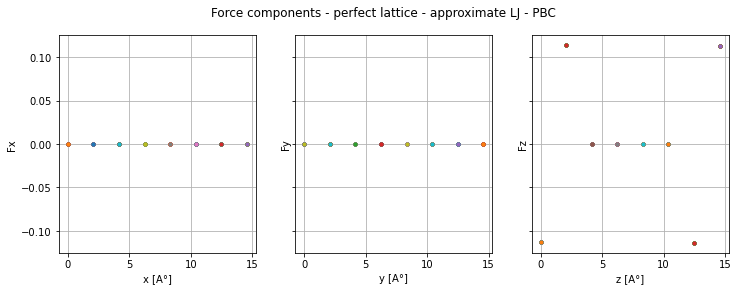

In [9]:
n_atoms,sx,sy,sz,x,y,z = lattice

fig,axs = plt.subplots(1,3,sharey=True,figsize=(12,4))

for i in range(255):
    axs[0].plot(x[i],FxA[i],'.')
    axs[1].plot(y[i],FyA[i],'.')
    axs[2].plot(z[i],FzA[i],'.')

for i in range(3):
    axs[i].grid()

axs[0].set_xlabel('x [A°]')
axs[0].set_ylabel('Fx')
axs[1].set_xlabel('y [A°]')
axs[1].set_ylabel('Fy')
axs[2].set_xlabel('z [A°]')
axs[2].set_ylabel('Fz')

fig.suptitle('Force components - perfect lattice - approximate LJ - PBC')
plt.show()

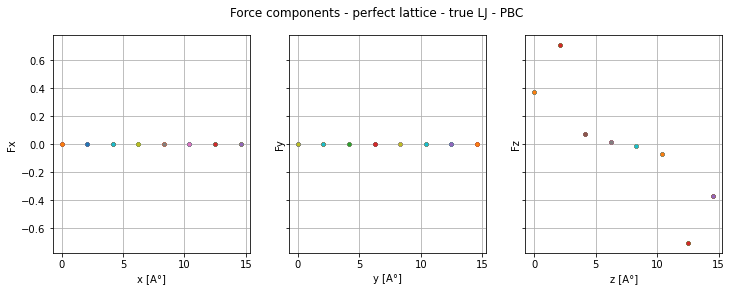

In [10]:
fig,axs = plt.subplots(1,3,sharey=True,figsize=(12,4))

for i in range(255):
    axs[0].plot(x[i],Fx[i],'.')
    axs[1].plot(y[i],Fy[i],'.')
    axs[2].plot(z[i],Fz[i],'.')

for i in range(3):
    axs[i].grid()

axs[0].set_xlabel('x [A°]')
axs[0].set_ylabel('Fx')
axs[1].set_xlabel('y [A°]')
axs[1].set_ylabel('Fy')
axs[2].set_xlabel('z [A°]')
axs[2].set_ylabel('Fz')

fig.suptitle('Force components - perfect lattice - true LJ - PBC')
plt.show()

In [11]:
# initializing speed
m_ag = 108*1.66e-27/16
kb = 1/11603
T = 100

start = time.process_time()
vx,vy,vz = basic.initialize_speed(n_atoms,x,y,z,T,remove_translation=True)
print(f'speed initialization; computing time: {time.process_time() - start :.3f} seconds\n')

v2 = vx**2 + vy**2  + vz**2
Ekin = 0.5*m_ag*np.sum(v2)
Tkin = 2*Ekin/(3*n_atoms*kb)  

print('translation removal check:')
print(f'    mean vx: {np.mean(vx)}')
print(f'    mean vy: {np.mean(vy)}')
print(f'    mean vz: {np.mean(vz)}\n')
print(f'Set temperature: {T:.2f}K; real temperature: {Tkin:.2f}K')

speed initialization; computing time: 0.002 seconds

translation removal check:
    mean vx: 0.0001983642578125
    mean vy: 0.0001049041748046875
    mean vz: -0.00014495849609375

Set temperature: 100.00K; real temperature: 100.00K


### Full simulation using built-in function

#### No PBC, no approx

In [13]:
filename = "fcc100a256.txt"
timelength = 12e-12    
timestep = 1.5e-14   
T = 50

results = main.make_simulation(filename,T,timelength,timestep)
time_array,all_x,all_y,all_z,Temp_array,energy_array = results

Translation removal check:
    mean vx: -3.814697265625e-06
    mean vy: 7.05718994140625e-05
    mean vz: 0.00016021728515625

Set temperature: 50.00K; real temperature: 50.00K 



  0%|          | 0/800 [00:00<?, ?it/s]

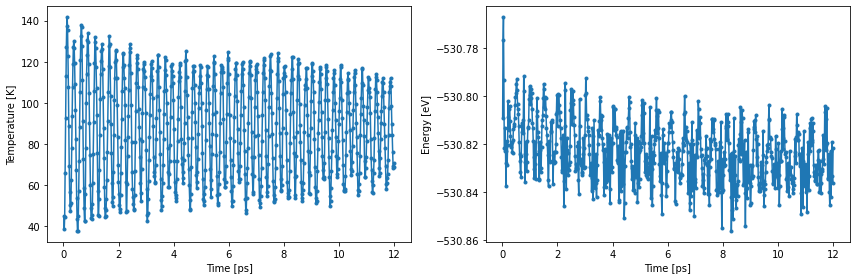

In [14]:
fig,axs = plt.subplots(1,2,figsize=(12,4))

axs[0].plot(time_array*1e12,Temp_array,'.-')
axs[1].plot(time_array*1e12,energy_array,'.-')

for ax in axs:
    ax.set_xlabel('Time [ps]')

axs[0].set_ylabel('Temperature [K]')
axs[1].set_ylabel('Energy [eV]')

fig.tight_layout()

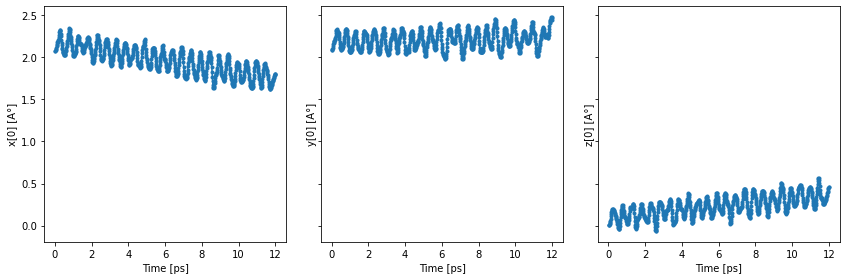

In [15]:
fig,axs = plt.subplots(1,3,sharey=True,figsize=(12,4))

axs[0].plot(time_array*1e12,all_x[0],'.-')
axs[1].plot(time_array*1e12,all_y[0],'.-')
axs[2].plot(time_array*1e12,all_z[0],'.-')

for ax in axs:
    ax.set_xlabel('Time [ps]')
    
axs[0].set_ylabel('x[0] [A°]')
axs[1].set_ylabel('y[0] [A°]')
axs[2].set_ylabel('z[0] [A°]')

fig.tight_layout()

#### PBC, approx

In [16]:
filename = "fcc100a256.txt"
timelength = 12e-12    
timestep = 1.5e-14   
T = 100

results = main.make_simulation(filename,T,timelength,timestep,PBC=True,approx=True)
time_array,all_x,all_y,all_z,Temp_array,energy_array = results

Translation removal check:
    mean vx: 0.000148773193359375
    mean vy: -8.7738037109375e-05
    mean vz: -4.1961669921875e-05

Set temperature: 100.00K; real temperature: 100.00K 



  0%|          | 0/800 [00:00<?, ?it/s]

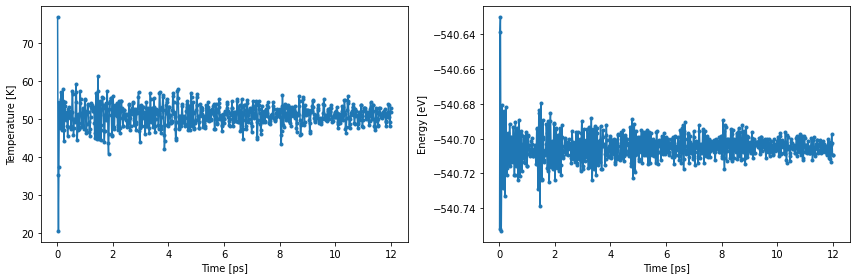

In [18]:
fig,axs = plt.subplots(1,2,figsize=(12,4))

axs[0].plot(time_array*1e12,Temp_array,'.-')
axs[1].plot(time_array*1e12,energy_array,'.-')

for ax in axs:
    ax.set_xlabel('Time [ps]')

axs[0].set_ylabel('Temperature [K]')
axs[1].set_ylabel('Energy [eV]')

fig.tight_layout()

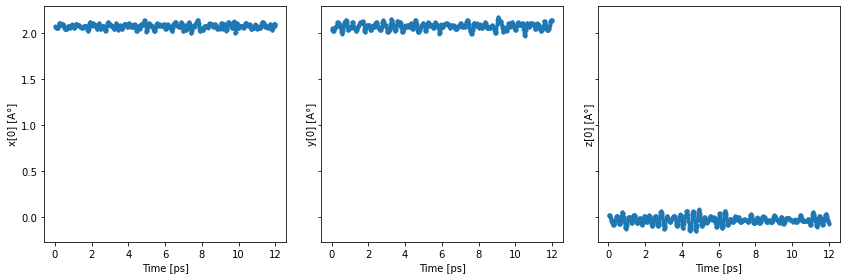

In [19]:
fig,axs = plt.subplots(1,3,sharey=True,figsize=(12,4))

axs[0].plot(time_array*1e12,all_x[0],'.-')
axs[1].plot(time_array*1e12,all_y[0],'.-')
axs[2].plot(time_array*1e12,all_z[0],'.-')

for ax in axs:
    ax.set_xlabel('Time [ps]')
    
axs[0].set_ylabel('x[0] [A°]')
axs[1].set_ylabel('y[0] [A°]')
axs[2].set_ylabel('z[0] [A°]')

fig.tight_layout()

### Full simulation with built-in functions

In [20]:
filename = "fcc100a256.txt"
timelength = 12e-12    
timestep = 1.5e-14   
T = 100

lattice = basic.read_file(filename)
results = main.make_simulation(filename,T,timelength,timestep,PBC=True,approx=True)
time_array,all_x,all_y,all_z,Temp_array,energy_array = results

Translation removal check:
    mean vx: -0.000209808349609375
    mean vy: 2.288818359375e-05
    mean vz: -2.09808349609375e-05

Set temperature: 100.00K; real temperature: 100.00K 



  0%|          | 0/800 [00:00<?, ?it/s]

In [21]:
dump_time = 5e-12
df50 = main.build_results_df(T/2,lattice,results,dump_time)

In [22]:
df50.head()

,x0,y0,z0,simulation_time,rejected_time,timestep,temperature_goal,temperature_mean,temperature_std,energy_mean,energy_std,status,x_mean,x_std,y_mean,y_std,z_mean,z_std
0,2.0802,2.0802,0.0,1.200000e-11,4.995000e-12,1.500000e-14,25.0,50.977568,2.347559,-540.70731,0.005015,Success,2.080494,0.024955,2.080645,0.035358,-0.032624,0.031703
1,0.0000,0.0000,0.0,1.200000e-11,4.995000e-12,1.500000e-14,25.0,50.977568,2.347559,-540.70731,0.005015,Success,0.000855,0.029140,-0.000711,0.033302,-0.032206,0.039925
2,0.0000,4.1604,0.0,1.200000e-11,4.995000e-12,1.500000e-14,25.0,50.977568,2.347559,-540.70731,0.005015,Success,-0.000417,0.023243,4.160667,0.031424,-0.031376,0.027971
3,2.0802,6.2406,0.0,1.200000e-11,4.995000e-12,1.500000e-14,25.0,50.977568,2.347559,-540.70731,0.005015,Success,2.079708,0.025058,6.241160,0.031263,-0.031828,0.036041
4,0.0000,8.3208,0.0,1.200000e-11,4.995000e-12,1.500000e-14,25.0,50.977568,2.347559,-540.70731,0.005015,Success,-0.000266,0.027008,8.320617,0.031079,-0.032265,0.042745


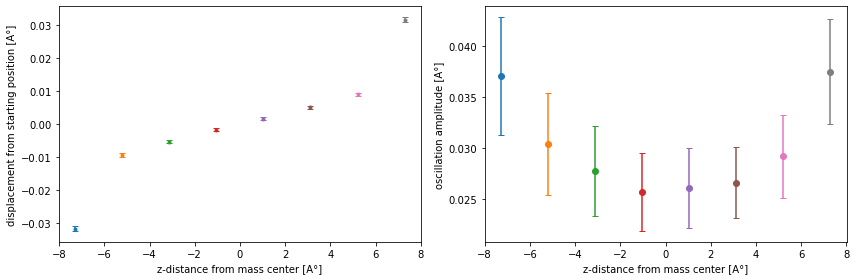

In [24]:
fig,axs = plt.subplots(1,2,figsize=(12,4))

for ix,(z0,z0_group) in enumerate(df50.groupby('z0')):
    axs[0].errorbar(z0_group['z0'].mean()-df50['z0'].mean(),z0_group['z_mean'].mean()-z0_group['z0'].mean(),
                    yerr=z0_group['z_mean'].std(),fmt='.-',capsize=3)
    axs[1].errorbar(z0_group['z0'].mean()-df50['z0'].mean(),z0_group['z_std'].mean(),
                    yerr=z0_group['z_std'].std(),fmt='o-',capsize=3)
    
for ax in axs:
    ax.set_xlabel('z-distance from mass center [A°]')
axs[0].set_ylabel('displacement from starting position [A°]')
axs[1].set_ylabel('oscillation amplitude [A°]')
fig.tight_layout()

### More simulations in a row, saving results

In [25]:
import json
configs = pd.read_json('configs.json')

In [26]:
print(configs.to_string())

                                                                                         simulation_list
0                 {'temperature': 100, 'timestep': 1.5e-14, 'total_time': 2e-11, 'rejected_time': 8e-12}
1                   {'temperature': 200, 'timestep': 1e-14, 'total_time': 2e-11, 'rejected_time': 8e-12}
2                   {'temperature': 400, 'timestep': 5e-15, 'total_time': 2e-11, 'rejected_time': 8e-12}
3  {'temperature': 800, 'timestep': 2.5000000000000004e-15, 'total_time': 2e-11, 'rejected_time': 8e-12}


In [27]:
import os

filename = "fcc100a256.txt"

for config in configs.simulation_list:
    temperature = config['temperature']
    timestep = config['timestep']
    total_time = config['total_time']
    rejected_time = config['rejected_time']
    lattice = basic.read_file(filename)
    if os.path.exists(f'results/results_T{temperature}.xlsx'):
        df = pd.read_excel(f'results/results_T{temperature}.xlsx')
        status = df.status.unique()
        if status[0]=='Success':
            print(f'T={temperature}: previous simulation results exist; simulation status: success.')
        else: 
            print(f'T={temperature}: previous simulation results exist; simulation status: fail; new simulation will be executed.')
            results = main.make_simulation(filename,temperature,total_time,timestep,PBC=True,approx=True)
            df = main.build_results_df(temperature,lattice,results,rejected_time)
            df.to_excel(f'results/results_T{temperature}.xlsx')
    else:
        results = main.make_simulation(filename,temperature,total_time,timestep,PBC=True,approx=True)
        df = main.build_results_df(temperature,lattice,results,rejected_time)
        df.to_excel(f'results/results_T{temperature}.xlsx')

T=100: previous simulation results exist; simulation status: success.
T=200: previous simulation results exist; simulation status: success.
T=400: previous simulation results exist; simulation status: success.
T=800: previous simulation results exist; simulation status: success.


### Example plots

In [28]:
df_tot = []

for config in configs.simulation_list:
    temperature = config['temperature']
    if os.path.exists(f'results/results_T{temperature}.xlsx'):
        df = pd.read_excel(f'results/results_T{temperature}.xlsx')
        status = df.status.unique()
        if status[0]=='Success':
            df_tot.append(df)      

df_tot = pd.concat(df_tot, axis=0, ignore_index=True)
df_tot.drop(['Unnamed: 0'], axis=1, inplace=True)

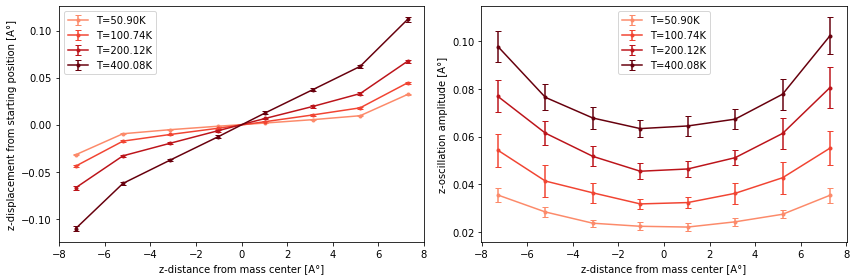

In [30]:
from matplotlib import cm

colors = cm.Reds(np.linspace(0.4,1,len(df_tot.temperature_goal.unique())))

fig,axs = plt.subplots(1,2,figsize=(12,4))

for ix,(temperature,temperature_df) in enumerate(df_tot.groupby('temperature_mean')):
    color = colors[ix]
    z0 = temperature_df.groupby('z0').z0.mean() - temperature_df['z0'].mean()
    z_displacement = temperature_df.groupby('z0').z_mean.mean() -  temperature_df.groupby('z0').z0.mean()
    z_displacement_err = temperature_df.groupby('z0').z_mean.std()
    z_amplitude = temperature_df.groupby('z0').z_std.mean()
    z_amplitude_err = temperature_df.groupby('z0').z_std.std()
    axs[0].errorbar(z0,z_displacement,yerr=z_displacement_err,fmt='.-',color=color,capsize=3,
                    label=f'T={temperature:.2f}K')
    axs[1].errorbar(z0,z_amplitude,yerr=z_amplitude_err,fmt='.-',color=color,capsize=3,
                    label=f'T={temperature:.2f}K')
    
for ax in axs:
    ax.set_xlabel('z-distance from mass center [A°]')
    ax.legend()
axs[0].set_ylabel('z-displacement from starting position [A°]')
axs[1].set_ylabel('z-oscillation amplitude [A°]')
fig.tight_layout()

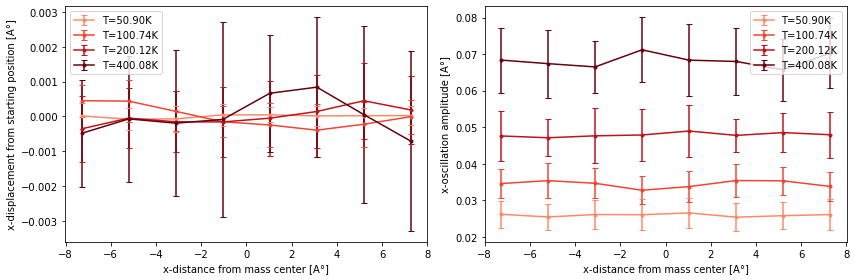

In [31]:
fig,axs = plt.subplots(1,2,figsize=(12,4))

for ix,(temperature,temperature_df) in enumerate(df_tot.groupby('temperature_mean')):
    color = colors[ix]
    x0 = temperature_df.groupby('x0').x0.mean() - temperature_df['x0'].mean()
    x_displacement = temperature_df.groupby('x0').x_mean.mean() -  temperature_df.groupby('x0').x0.mean()
    x_displacement_err = temperature_df.groupby('x0').x_mean.std()
    x_amplitude = temperature_df.groupby('x0').x_std.mean()
    x_amplitude_err = temperature_df.groupby('x0').x_std.std()
    axs[0].errorbar(x0,x_displacement,yerr=x_displacement_err,fmt='.-',color=color,capsize=3,
                    label=f'T={temperature:.2f}K')
    axs[1].errorbar(x0,x_amplitude,yerr=x_amplitude_err,fmt='.-',color=color,capsize=3,
                    label=f'T={temperature:.2f}K')
    
for ax in axs:
    ax.set_xlabel('x-distance from mass center [A°]')
    ax.legend()
axs[0].set_ylabel('x-displacement from starting position [A°]')
axs[1].set_ylabel('x-oscillation amplitude [A°]')
fig.tight_layout()

### Test zone - used for quick tests and monkey patch